# Introduction

In this notebook, we present data analysis on Chatbot Arena data collected from https://arena.lmsys.org.

We explain different Elo calculation methods (online Elo and MLE Elo, also known as Bradley-Terry model) for model ranking.

To view the latest leaderboard, see https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard.


In [ ]:
from collections import defaultdict
import json, math, gdown
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import requests
pd.options.display.float_format = '{:.2f}'.format

# Obtaining and Cleaning the Tournament Data
We are hosting the initial tournament results as a JSON file on Google Drive. We use the `gdown` function to download the data. The data contains all the battels and voting results collected for ranking models.

In [ ]:
# we use the latest data
url = "https://storage.googleapis.com/arena_external_data/public/clean_battle_20240501.json"
response = requests.get(url)

with open('local_file_name.json', 'wb') as file:
    file.write(response.content)

# load the JSON data from the local file
with open('local_file_name.json', 'r') as file:
    battles = pd.read_json(file).sort_values(ascending=True, by=["tstamp"])

In [ ]:
battles.iloc[0]


model_a                                                   vicuna-13b
model_b                                                    koala-13b
winner                                                       model_a
judge                              arena_user_g6gsrz7UxqMFPbgwcaQ8yV
turn                                                               1
anony                                                          False
language                                                     English
tstamp                                                 1681813950.52
num_tokens_info    {'user_tokens': 9, 'context_a_tokens': 9, 'con...
is_code                                                         True
is_refusal                                                     False
Name: 0, dtype: object

In [ ]:
battles = battles[battles["anony"] == True]
print(len(battles))

910122


# Exploratory Analysis

Before computing the Elo ratings, we first conduct some basic exploratory analysis to highlight a few key properties and caveates with this data.

## Statistics

We allowed the user to declare a tie between the pairs of models.  To collect additional data, later in the tournament we also allowed the user to declare a tie in which both models were bad.  There were a significant portion of tied outcomes.

In [ ]:
fig = px.bar(battles["winner"].value_counts(),
             title="Counts of Battle Outcomes", text_auto=True, height=400)
fig.update_layout(xaxis_title="Battle Outcome", yaxis_title="Count",
                  showlegend=False)
fig

In [ ]:
battles_no_ties = battles[~battles["winner"].str.contains("tie")]

In [ ]:
import random
def compute_weights_sigmoid(P,E):
    learning_rate = 0.01
    max_iterations = 5000
    n = P.shape[0]
    w = np.zeros(n)
    for iter in range(max_iterations):
        gradient = np.zeros_like(w)
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    gradient[i] += 0.5*(P[i, j] + 1 - P[j,i]) -F(w[i]-w[j])
        if np.linalg.norm(gradient) < 1e-5:
            break
        w = w + learning_rate * gradient
        if iter== max_iterations-1:
            print('max iterations reached BTL')
    return w

def compute_test_statistic(what,Z2,K2):
    n = len(what)
    T = 0
    for i in range(n):
        for j in range(n):
            Fijhat = F(what[i] - what[j])
            if K2[i][j] > 1 and i!=j:
                T +=  (Z2[i][j] * (Z2[i][j] - 1)) / (K2[i][j] * (K2[i][j] - 1))  +    Fijhat**2    -    2*Fijhat*(Z2[i][j] / K2[i][j])
    return T

def F(x):
    return 1/(1+ np.exp(-x))


##############

def get_estimate_threshold(n,  K):
    syntZ = generate_synthetic_data(n, K)
    T0 = compute_Tfromlist(syntZ)
    return T0

def generate_synthetic_data(n, K):
    alphas = np.random.uniform(-1.47, 1.47, n)
    alphas = alphas - np.mean(alphas)
    Pb = np.zeros([n, n])

    for i in range(n):
        for j in range(n):
            if K[i,j]>0:
                Pb[i, j] = F(alphas[i] - alphas[j])
    np.fill_diagonal(Pb, 0)

    syntZ = [[[] for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j and K[i][j] > 0:
                syntZ[i][j] = np.random.binomial(1, Pb[i, j], int( K[i][j]))
            else:
                syntZ[i][j] = []
    return syntZ


def construct_Z_empirical_and_Kij(Zlist):
    n = len(Zlist)
    Z_empirical1 = [[0] * n for _ in range(n)]
    Kij1 = [[0] * n for _ in range(n)]
    Z_empirical2 = [[0] * n for _ in range(n)]
    Kij2 = [[0] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i != j:
                half_len = len(Zlist[i][j]) // 2
                Zlist1 = Zlist[i][j][:half_len]
                Zlist2 = Zlist[i][j][half_len:]

                count1 = sum(Zlist1)
                count2 = sum(Zlist2)
                Z_empirical1[i][j] = count1
                Z_empirical2[i][j] = count2

                Kij1[i][j] = len(Zlist1)
                Kij2[i][j] = len(Zlist2)

        Kij1[i][i] = 0
        Kij2[i][i] = 0

    return Z_empirical1, Kij1, Z_empirical2, Kij2



def compute_Tfromlist(Z):
    Zemp1 , K1, Zemp2, K2 = construct_Z_empirical_and_Kij(Z)
    n = len(K)
    Zemp1 = np.array(Zemp1)
    Zemp2 = np.array(Zemp2)
    K1 = np.array(K1)
    K2 = np.array(K2)
    Phat = np.where((K1 == 0), 0, Zemp1 / K1 )
    E = K1>0
    what = compute_weights_sigmoid(Phat,E)
    # print(what)
    T0 = compute_test_statistic(what,Zemp2,K2)
    return T0

In [ ]:
from scipy.special import erf

def compute_weights_qfunc(P,E):
    learning_rate = 0.01
    max_iterations = 4000
    n = P.shape[0]
    w = np.zeros(n)
    for iter in range(max_iterations):
        gradient = np.zeros_like(w)
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    gradient[i] += (P[i, j] + 1 - P[j,i]) * np.exp(- (w[j] - w[i])**2 / 2) / qfunc(w[i] - w[j]) \
                            - (1 - P[i, j] + P[j,i]) * np.exp(- (w[j] - w[i])**2 / 2) / qfunc(w[j] - w[i])
        if np.linalg.norm(gradient) < 1e-5:
            break
        w = w + learning_rate * gradient
        if iter== max_iterations-1:
            print('max iterations reached Thurstone')
    return w



def compute_test_statisticThurstone(what,Z2,K2):
    n = len(what)
    T = 0
    for i in range(n):
        for j in range(n):
            Fijhat = qfunc(what[i] - what[j])
            if K2[i,j] > 1 and i!=j:
                T +=  (Z2[i, j] * (Z2[i, j] - 1)) / (K2[i,j] * (K2[i,j] - 1))  +    Fijhat**2    -    2*Fijhat*(Z2[i,j] / K2[i,j])
    return T

def qfunc(x):
    return 1 - 0.5 * (1 - erf(x / np.sqrt(2)))


def get_estimate_thresholdThurstone(n,  K):
    syntZ = generate_synthetic_dataThurstone(n, K)
    T0 = compute_TfromlistThurstone(syntZ)
    return T0

def generate_synthetic_dataThurstone(n, K):
    alphas = np.random.uniform(-0.8, 0.8, n)
    alphas = alphas - np.mean(alphas)
    Pb = np.zeros([n, n])

    for i in range(n):
        for j in range(n):
            if K[i,j]>0:
                Pb[i, j] = qfunc(alphas[i] - alphas[j])
    np.fill_diagonal(Pb, 0)

    syntZ = [[[] for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j and K[i][j] > 0:
                syntZ[i][j] = np.random.binomial(1, Pb[i, j], int( K[i][j]))
            else:
                syntZ[i][j] = []
    return syntZ
def compute_TfromlistThurstone(Z):
    Zemp1 , K1, Zemp2, K2 = construct_Z_empirical_and_Kij(Z)
    n = len(K)
    Zemp1 = np.array(Zemp1)
    Zemp2 = np.array(Zemp2)
    K1 = np.array(K1)
    K2 = np.array(K2)
    Phat = np.where((K1 == 0), 0, Zemp1 / K1 )
    E = K1>0
    what = compute_weights_sigmoid(Phat,E)
    # print(what)
    T0 = compute_test_statistic(what,Zemp2,K2)
    return T0


In [ ]:
results = []
resultsT =[]

from google.colab import files
nfinal  = 23

concatenated_models = pd.concat([battles_no_ties["model_a"], battles_no_ties["model_b"]])
top_n = concatenated_models.value_counts().nlargest(nfinal).index.tolist()
print(f"Top {nfinal} models with highest battle count: {top_n}")


print(top_n[0])
# Filter matches with top both teams in top_n_models
filtered_matches = battles_no_ties[(battles_no_ties["model_a"].isin(top_n)) & (battles_no_ties["model_b"].isin(top_n))]

# Define E to be nxn matrix boolean matrix  where E[i, j ]> 0 if there is atleast one model_a = top_n[i] and model_b = top_n[j] comparison in these filtered matches
Etotal = np.zeros((nfinal, nfinal), dtype=bool)


Ztotal = [[[] for _ in range(nfinal)] for _ in range(nfinal)]
Ktotal = np.zeros([nfinal,nfinal])

for i in range(nfinal):
    for j in range(nfinal):
        comparisons = filtered_matches[(filtered_matches["model_a"] == top_n[i]) & (filtered_matches["model_b"] == top_n[j])].head(200)
        if len(comparisons)>30:
            # print(len(comparisons))
            Etotal[i][j] = True
            Ztotal[i][j] = (comparisons["winner"] == 'model_a').values
            Ktotal[i][j] = len(Ztotal[i][j])

for i in range(nfinal):
    for j in range(i+1,nfinal):
        if Etotal[i][j] != Etotal[j][i]:
            # print(len(comparisons))
            Etotal[i][j] = False
            Etotal[j][i] = False
            Ztotal[i][j] = []
            Ztotal[j][i] = []
            Ktotal[i][j] = 0
            Ktotal[j][i] = 0

print(Etotal)
print(Ktotal)



Top 23 models with highest battle count: ['claude-3-opus-20240229', 'claude-3-sonnet-20240229', 'gpt-4-1106-preview', 'gpt-4-0613', 'gpt-4-0125-preview', 'claude-3-haiku-20240307', 'mixtral-8x7b-instruct-v0.1', 'gpt-4-0314', 'llama-3-70b-instruct', 'llama-3-8b-instruct', 'mistral-large-2402', 'gpt-3.5-turbo-0125', 'command-r-plus', 'gpt-3.5-turbo-0613', 'claude-2.1', 'gemini-1.5-pro-api-0409-preview', 'llama-2-70b-chat', 'command-r', 'gpt-4-turbo-2024-04-09', 'mistral-medium', 'qwen1.5-72b-chat', 'dbrx-instruct-preview', 'snowflake-arctic-instruct']
claude-3-opus-20240229
[[False  True  True  True  True  True  True  True  True  True  True  True
   True False  True  True  True  True  True  True  True  True  True]
 [ True False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True

In [ ]:
print(len(Ztotal[0][1]))

200


In [ ]:
for n in range(5,24,2):
    # Define Z to be nxn collection of arrays where Z[i,j] is an array of size number of comparisons where model_a = top_n[i] and model_b = top_n[j] and true representing winner = model_a and false otherwise
    Z = [[[] for _ in range(n)] for _ in range(n)]
    K = np.zeros([n,n])
    E = np.zeros((n, n), dtype=bool)
    for i in range(n):
        for j in range(n):
            if Etotal[i, j]:
            # print(len(comparisons))
                Z[i][j] = Ztotal[i][j]
                K[i][j] = Ktotal[i][j]
                E[i][j] = Etotal[i][j]
    # Complete from here
    test_statistics = []
    test_statisticsT= []

    estimate_threshold = []
    estimate_thresholdT= []

    for iter in range(400):
        estimate_threshold.append(np.sum(K)*get_estimate_threshold(n, K)/(np.sum(E)*n))
        estimate_thresholdT.append(np.sum(K)*get_estimate_thresholdThurstone(n, K)/(np.sum(E)*n))
        if iter % 50 ==0:
            print(iter)
            print(estimate_threshold[-1],estimate_thresholdT[-1])
    print('95th ile thresholds  =  ', np.percentile(estimate_threshold,95),np.percentile(estimate_thresholdT,95) )

    for _ in range(100):
        # Shuffle Z[i][j] for every i,j in E
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    random.shuffle(Z[i][j])

        # Split Z into two parts Z1 and Z2
        Z1 = [[[] for _ in range(n)] for _ in range(n)]
        Z2 = [[[] for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    mid = len(Z[i][j]) // 2
                    Z1[i][j] = Z[i][j][:mid]
                    Z2[i][j] = Z[i][j][mid:]

        # Define P1 and Zemp2, K2 as nxn matrices
        P1 = np.zeros((n, n))
        Zemp2 = np.zeros((n, n))
        K2 = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    P1[i, j] = (sum(Z1[i][j]==True)) / len(Z1[i][j])
                    Zemp2[i, j] = sum(Z2[i][j]==True)
                    K2[i, j] = len(Z2[i][j])
        # Compute weights using P1 and the function below
        weights = compute_weights_sigmoid(P1,E)
        test_statistic = np.sum(K)*compute_test_statistic(weights,Zemp2,K2)/(np.sum(E)*n)
        test_statistics.append(test_statistic)
    for _ in range(100):
        # Shuffle Z[i][j] for every i,j in E
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    random.shuffle(Z[i][j])

        # Split Z into two parts Z1 and Z2
        Z1 = [[[] for _ in range(n)] for _ in range(n)]
        Z2 = [[[] for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    mid = len(Z[i][j]) // 2
                    Z1[i][j] = Z[i][j][:mid]
                    Z2[i][j] = Z[i][j][mid:]

        # Define P1 and Zemp2, K2 as nxn matrices
        P1 = np.zeros((n, n))
        Zemp2 = np.zeros((n, n))
        K2 = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if E[i, j]:
                    P1[i, j] = (sum(Z1[i][j]==True)) / len(Z1[i][j])
                    Zemp2[i, j] = sum(Z2[i][j]==True)
                    K2[i, j] = len(Z2[i][j])
        # Compute weights using P1 and the function below
        weightsT= compute_weights_qfunc(P1,E)

        # Compute test_statistic using the function below
        test_statisticT= np.sum(K)*compute_test_statisticThurstone(weightsT,Zemp2,K2)/(np.sum(E)*n)
        test_statisticsT.append(test_statisticT)
    # I want to store estimate_threshold and test_statistics arrays for every n
    print(np.matmul( P1,np.ones([n,1])).T)
    print(weights, weightsT)

    results.append((n, np.sum(K)/np.sum(E) ,  test_statistics, estimate_threshold))
    resultsT.append((n, np.sum(K)/np.sum(E) ,  test_statisticsT, estimate_thresholdT))
    print(np.percentile(test_statistics,95) )
    print(np.percentile(test_statisticsT,95) )
    print('Loook Here =>', [np.mean( test_statistics > np.percentile(estimate_threshold,95))*100,100*np.mean(test_statisticsT>np.percentile(estimate_thresholdT,95))])

<ipython-input-7-5d49eafbece6>:98: RuntimeWarning:

invalid value encountered in divide

<ipython-input-8-7a67bbe4ec20>:69: RuntimeWarning:

invalid value encountered in divide



0
0.2239033703247778 0.8841153631467974
50
1.0629525533569095 1.555105532631842
100
4.1590931551178265 1.5674188723424132
150
0.3960656820935671 1.0408360841509066
200
1.273648998799063 0.6754785906143013
250
-0.32391822232810197 0.4087573898580202
300
0.7449577788368247 0.11164060145317879
350
-0.18859830642098174 -0.284871734075165
95th ile thresholds  =   1.5168325695562606 1.6501056049659637
[[2.29 1.58 2.37 1.45 2.23]]
[ 0.25371853 -0.22087643  0.31645844 -0.54486298  0.19556244] [ 0.15725033 -0.21318834  0.19851392 -0.27125683  0.12868092]
1.7419316037271944
1.7381691021724237
Loook Here => [14.000000000000002, 8.0]
0
-1.2563125849461165 0.2139224958301236
50
0.38640555207975225 2.3511004990244784
100
0.35234912917558847 0.427094509855021
150
0.5280617388384236 0.23628788860834218
200
0.1546620308946832 0.19140671567091105
250
0.8265674916628297 0.22364736413547637
300
-0.10148630289167478 0.3232600883453427
350
-0.27879214984209344 -0.7652397314860707
95th ile thresholds  =   1.

[5 7 9 11 13 15 17 19 21 23]
[200.0 200.0 200.0 200.0 199.96794871794876 197.44845360824743
 193.14285714285717 191.122641509434 186.92424242424244 181.79324894514767]
s [400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


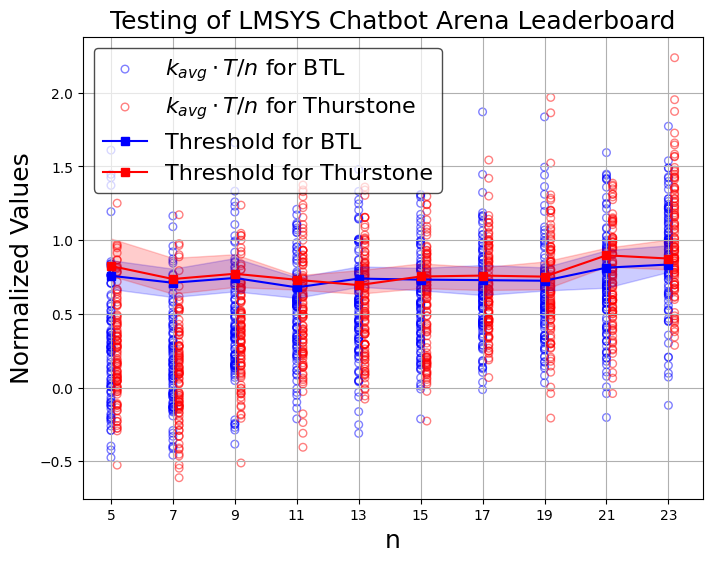

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


results_df = pd.read_csv('./resultsconcat.csv')
res = results_df.to_numpy()
# res = np.delete(res, 1, axis=0)
resultsT_df = pd.read_csv('./resultsTconcat.csv')
resT = resultsT_df.to_numpy()
# resT = np.delete(resT, 1, axis=0)
# Extract the data from the results array
n_values = res[:, 0]
K_avg = resT[:, 1]

print(n_values)
print(K_avg)
# print(test_statistics)
# print(estimate_threshold)
import ast

T_statistics = [ast.literal_eval(stats) for stats in res[:, 2]]
T_statisticsT = [ast.literal_eval(stats) for stats in resT[:, 2]]
est_thd = [ast.literal_eval(thresh) for thresh in res[:, 3]]
est_thdT = [ast.literal_eval(thresh) for thresh in resT[:, 3]]
# Calculate the 95th percentile thresholds
thd_95th = 0.5* np.array([np.percentile(thresh,95) for thresh in est_thd])
thd_95thT = 0.5 * np.array([np.percentile(thresh,95) for thresh in est_thdT])

# Calculate the 91st and 99th percentiles for error bars
thd_91st = 0.5*np.array([np.percentile(thresh, 92.5) for thresh in est_thd])
thd_99th = 0.5*np.array([np.percentile(thresh, 97) for thresh in est_thd])
thd_91stT =0.5* np.array([np.percentile(thresh, 92.5) for thresh in est_thdT])
thd_99thT = 0.5*np.array([np.percentile(thresh, 97) for thresh in est_thdT])
# Calculate error bars
error_bars_btl = [thd_95th - thd_91st, thd_99th - thd_95th]
error_bars_thurstone = [thd_95thT - thd_91stT, thd_99thT - thd_95thT]


# Create the plot
plt.figure(figsize=(8, 6))

# Set colors for T_statistics and T_statisticsT
color_T = (0, 0, 1, 0.5)  # Light blue with 50% opacity
color_TT = (1, 0, 0, 0.5)  # Light red with 50% opacity

# Set colors for estimated thresholds
color_thd = 'blue'
color_thdT = 'red'
labels = ['$k_{avg}\cdot T/n$ for BTL', '$k_{avg}\cdot T/n$ for Thurstone']



print('s',[len(est_thd[i]) for i in range(len(n_values))])
# Concatenate the arrays
T_statistics_all = 0.5*np.concatenate(T_statistics)
T_statisticsT_all = 0.5*np.concatenate(T_statisticsT)
n_values_all = np.repeat(n_values, [len(T_statistics[i]) for i in range(len(n_values))])
n_values_allT = np.repeat(np.array(n_values)+0.2, [len(T_statistics[i]) for i in range(len(n_values))])

# # Plot the scatter plots
plt.scatter(n_values_all, T_statistics_all, label=labels[0], marker='o', edgecolors=color_T, facecolors='none', s=30)
plt.scatter(n_values_allT, T_statisticsT_all, label=labels[1], marker='o', edgecolors=color_TT, facecolors='none', s=30)

n_values = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
plt.plot(n_values, thd_95th, label='Threshold for BTL', marker='s', color='blue')
plt.fill_between( n_values, thd_91st, thd_99th, color='blue', alpha=0.2)

plt.plot(n_values, thd_95thT, label='Threshold for Thurstone', marker='s', color='red')
plt.fill_between(n_values, thd_91stT, thd_99thT, color='red', alpha=0.2)




# # Set xticks to n_values
plt.xticks(n_values)
plt.xlabel('n', fontsize=18)
plt.ylabel('Normalized Values', fontsize=18)
plt.title('Testing of LMSYS Chatbot Arena Leaderboard', fontsize = 18)
plt.legend(fontsize=16, edgecolor='black', facecolor='white', framealpha=0.7)
plt.grid(True)
plt.savefig('plotLymsys.pdf')
plt.show()


In [ ]:

# from google.colab import drive

df = pd.DataFrame(results, columns=['n', 'k_avg', 'test_statistics', 'estimate_threshold'])
dfT = pd.DataFrame(resultsT, columns=['n', 'k_avg', 'test_statistics', 'estimate_threshold'])
df.to_csv('resultsconcat.csv', index=False)
dfT.to_csv('resultsTconcat.csv', index=False)
# # Mount your Google Drive account
# drive.mount('/content/gdrive')

# # Save the file to your Google Drive account
# with open('results.csv', 'r') as f:
#     drive.flush_and_unmount()
#     drive.mount('/content/gdrive')
#     with open('/content/gdrive/MyDrive/results.csv', 'w') as f_out:
#         f_out.write(f.read())

# Download the file to your local system
files.download('resultsconcat.csv')
files.download('resultsTconcat.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>